# Digit Classification - CNN
# Helia Ghahreman - Sobhan Mahmoodi

# 1. Imports

In [2]:
import torch
import pickle
import numpy as np
import torch.nn as nn
from sklearn import svm
from tqdm import trange
import torch.optim as optim
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/CI-Final-Project'
from torch.functional import F
import matplotlib.pyplot as plt
from myutils import get_data_loaders
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from myutils import custom_plot_training_stats

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1tSq_vUxR18U8YdM1apqnIN6qayDVpCCh/CI-Final-Project


# 2. Data Loading

In [3]:
BATCH_SIZE = 64
full_dataloaders, _ = get_data_loaders(
    filenames={
        'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
        'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
    },
    batch_size=BATCH_SIZE
)

datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


# 3. GPU

In [4]:
use_gpu = True
device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")
device

device(type='cuda', index=0)

# 4. CNN Architecture

In [5]:
class digit_classifier_model(nn.Module):
    def __init__(self):
        super(digit_classifier_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=32 * 8 * 8 + 256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, images, feature_vectors, domain_labels, triplet_alpha, svm):
        x0 = F.relu(self.conv1(images))
        x1 = F.max_pool2d(x0, 2)
        x2 = F.relu(self.conv2(x1))
        x3 = F.max_pool2d(x2, 2)
        representations = x3.view(x3.size(0), -1)
        if svm:
            return representations
        concat = torch.cat((representations, feature_vectors), dim=1)
        x5 = F.relu(self.fc1(concat))
        x6 = F.relu(self.fc2(x5))
        predictions = self.fc3(x6)

        return predictions, triplet_loss().forward(concat, domain_labels, triplet_alpha)

# 5. Train model

In [6]:
def train_one_epoch(model: nn.Module, loss_func, optimizer: torch.optim.Optimizer, train_data_loader: DataLoader, triplet_lambda: float, alpha: float, add_cross):
    num_samples = len(train_data_loader.dataset)
    num_batches = len(train_data_loader)
    correct = 0
    total_loss = 0.0
    model.train()
    for batch_index, (images, features, domain_labels, digit_labels) in enumerate(train_data_loader):
        images = images.to(device)
        features = features.to(device)
        domain_labels = domain_labels.to(device)
        digit_labels = digit_labels.to(device)
        outputs, triplet_loss = model(images, features, domain_labels, alpha, False)
        classification_loss = loss_func(outputs, digit_labels)
        loss = classification_loss
        if add_cross:
          loss += triplet_loss * triplet_lambda

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        _, predictions = torch.max(outputs, dim=1)
        correct += torch.sum(predictions == digit_labels)
        total_loss += loss.item()
    epoch_accuracy = (correct / num_samples) * 100
    epoch_loss = total_loss / num_batches

    return [epoch_accuracy, triplet_loss, classification_loss, epoch_loss]

In [7]:
def train(alpha: float, lr: float, triplet_lambda: float, return_model, add_cross):
    model = digit_classifier_model()
    model = model.to(device)
    cross_entropy_loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    acc_history = {'train': [], 'test': [], 'test_missing': []}
    triplet_loss_history = {'train': [], 'test': [], 'test_missing': []}
    classification_loss_history = {'train': [], 'test': [], 'test_missing': []}
    loss_history = {'train': [], 'test': [], 'test_missing': []}
    for epoch in trange(10):
        train_acc, train_triplet_loss, train_classification_loss, train_loss = train_one_epoch(model, cross_entropy_loss_func, optimizer, full_dataloaders['train'],
                                                                                               triplet_lambda, alpha, add_cross)
        acc_history['train'].append(train_acc)
        triplet_loss_history['train'].append(train_triplet_loss)
        classification_loss_history['train'].append(train_classification_loss)
        loss_history['train'].append(train_loss)

        test_acc, test_triplet_loss, test_classification_loss, test_loss = test_model(model, cross_entropy_loss_func, full_dataloaders['test'],
                                                                                      triplet_lambda, alpha, add_cross)
        acc_history['test'].append(test_acc)
        triplet_loss_history['test'].append(test_triplet_loss)
        classification_loss_history['test'].append(test_classification_loss)
        loss_history['test'].append(test_loss)

        test_missing_acc, test_missing_triplet_loss, test_missing_classification_loss, test_missing_loss = test_model(model, cross_entropy_loss_func, full_dataloaders['test_missing'],
                                                                                                                      triplet_lambda, alpha, add_cross)
        acc_history['test_missing'].append(test_missing_acc)
        triplet_loss_history['test_missing'].append(test_missing_triplet_loss)
        classification_loss_history['test_missing'].append(test_missing_classification_loss)
        loss_history['test_missing'].append(test_missing_loss)
    if return_model:
        return [[acc_history, triplet_loss_history, classification_loss_history, loss_history], [model, cross_entropy_loss_func, optimizer]]
    return [acc_history, triplet_loss_history, classification_loss_history, loss_history]

# 6. Test Model

In [8]:
def test_model(model: nn.Module, loss_func, train_data_loader: DataLoader, triplet_lambda: float, alpha: float, add_cross):
    num_samples = len(train_data_loader.dataset)
    num_batches = len(train_data_loader)
    correct = 0
    total_loss = 0.0

    model.eval()
    with torch.no_grad():
       for batch_index, (images, features, domain_labels, digit_labels) in enumerate(train_data_loader):
            images = images.to(device)
            features = features.to(device)
            domain_labels = domain_labels.to(device)
            digit_labels = digit_labels.to(device)
            outputs, triplet_loss = model(images, features, domain_labels, alpha, False)
            classification_loss = loss_func(outputs, digit_labels)
            loss = classification_loss
            if add_cross:
                loss += triplet_loss * triplet_lambda
            _, predictions = torch.max(outputs, dim=1)
            correct += torch.sum(predictions == digit_labels)
            total_loss += loss.item()

    epoch_accuracy = (correct / num_samples) * 100
    epoch_loss = total_loss / num_batches

    return [epoch_accuracy, triplet_loss, classification_loss, epoch_loss]

# 7. Triplet Loss

In [9]:
class triplet_loss(nn.Module):
    def __init__(self, alpha: float = 0, device = device) -> None:
        super().__init__()
        self.alpha = torch.tensor(alpha)
        self.device = device

    def forward(self, embeddings, labels, triplet_alpha):
        self.alpha = triplet_alpha
        batch_size = embeddings.size(0)
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = 0
        for index in range(batch_size):
            triplet_loss += max(dp[index] - dn[index] + self.alpha, 0)
        return triplet_loss / batch_size

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)
        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(self.device))
        dp, _ = torch.max(dists * (positive_mask.int()), dim=1)
        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])
        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)

# 8. Plot Result

In [10]:
def info_to_plot(result, plot_name, show):
    train_accs = result[0]['train']
    train_triplet_losses = result[1]['train']
    train_classification_losses = result[2]['train']
    train_total_losses = result[3]['train']

    test_accs = result[0]['test']
    test_triplet_losses = result[1]['test']
    test_classification_losses = result[2]['test']
    test_total_losses = result[3]['test']

    test_missing_accs = result[0]['test_missing']
    test_missing_triplet_losses = result[1]['test_missing']
    test_missing_classification_losses = result[2]['test_missing']
    test_missing_total_losses = result[3]['test_missing']

    train_accs = np.array([item.item() if hasattr(item, 'item') else item for item in train_accs])
    train_triplet_losses = np.array([item.item() if hasattr(item, 'item') else item for item in train_triplet_losses])
    train_classification_losses = np.array([item.item() if hasattr(item, 'item') else item for item in train_classification_losses])
    train_total_losses = np.array([item.item() if hasattr(item, 'item') else item for item in train_total_losses])

    test_accs = np.array([item.item() if hasattr(item, 'item') else item for item in test_accs])
    test_triplet_losses = np.array([item.item() if hasattr(item, 'item') else item for item in test_triplet_losses])
    test_classification_losses = np.array([item.item() if hasattr(item, 'item') else item for item in test_classification_losses])
    test_total_losses = np.array([item.item() if hasattr(item, 'item') else item for item in test_total_losses])

    test_missing_accs = np.array([item.item() if hasattr(item, 'item') else item for item in test_missing_accs])
    test_missing_triplet_losses = np.array([item.item() if hasattr(item, 'item') else item for item in test_missing_triplet_losses])
    test_missing_classification_losses = np.array([item.item() if hasattr(item, 'item') else item for item in test_missing_classification_losses])
    test_missing_total_losses = np.array([item.item() if hasattr(item, 'item') else item for item in test_missing_total_losses])

    plotter(train_accs, train_triplet_losses, train_classification_losses, train_total_losses,
            test_accs, test_triplet_losses, test_classification_losses, test_total_losses,
            test_missing_accs, test_missing_triplet_losses, test_missing_classification_losses, test_missing_total_losses, plot_name, show)


In [11]:
def plotter(train_accs, train_triplet_losses, train_classification_losses, train_total_losses,
             test_accs, test_triplet_losses, test_classification_losses, test_total_losses,
             test_missing_accs, test_missing_triplet_losses, test_missing_classification_losses, test_missing_total_losses, plot_name, show):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    axs[0, 0].plot(range, train_accs, color='red', label='Train')
    axs[0, 0].plot(range, test_accs, color='green', label='Test')
    axs[0, 0].plot(range, test_missing_accs, color='blue', label='Test Missing')
    axs[0, 0].set_title('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend()

    axs[0, 1].plot(range, train_triplet_losses, color='orange', label='Train')
    axs[0, 1].plot(range, test_triplet_losses, color='purple', label='Test')
    axs[0, 1].plot(range, test_missing_triplet_losses, color='cyan', label='Test Missing')
    axs[0, 1].set_title('Triplet Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Triplet Loss')
    axs[0, 1].legend()

    axs[1, 0].plot(range, train_classification_losses, color='magenta', label='Train')
    axs[1, 0].plot(range, test_classification_losses, color='yellow', label='Test')
    axs[1, 0].plot(range, test_missing_classification_losses, color='brown', label='Test Missing')
    axs[1, 0].set_title('Classification Loss')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Classification Loss')
    axs[1, 0].legend()

    axs[1, 1].plot(range, train_total_losses, color='red', label='Train')
    axs[1, 1].plot(range, test_total_losses, color='green', label='Test')
    axs[1, 1].plot(range, test_missing_total_losses, color='blue', label='Test Missing')
    axs[1, 1].set_title('Total Loss')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Total Loss')
    axs[1, 1].legend()

    plt.tight_layout()

    plt.savefig(plot_name, dpi=100)
    if not show:
        plt.close(fig)

# 9. Best Triplet Alpha, Learning Rate, Triplet Lambda

In [ ]:
lam = 0.3
alp = 0.005
for learn_rate in [0.001, 0.01, 0.1]:
  plot_name = 'lam:' + str(lam) + 'learn_rate:' + str(learn_rate) + 'alp:' + str(alp) + '.png'
  result = train(alp, learn_rate, lam, False, True)
  info_to_plot(result, plot_name, False, False)

100%|██████████| 10/10 [09:30<00:00, 57.07s/it]


In [ ]:
lam = 0.3
alp = 0.005
for learn_rate in [0.0005, 0.001, 0.005]:
  plot_name = 'lam:' + str(lam) + 'learn_rate:' + str(learn_rate) + 'alp:' + str(alp) + '.png'
  result = train(alp, learn_rate, lam, False, True)
  info_to_plot(result, plot_name, False, False)

100%|██████████| 10/10 [09:21<00:00, 56.11s/it]


In [ ]:
learn_rate = 0.001
alp = 0.005
for l in [0.01, 0.05, 1/14]:
  plot_name = 'lam:' + str(l) + 'learn_rate:' + str(learn_rate) + 'alp:' + str(alp) + '.png'
  result = train(alp, learn_rate, l, False, True)
  info_to_plot(result, plot_name, False, False)

 40%|████      | 4/10 [03:46<05:39, 56.65s/it]

In [ ]:
learn_rate = 0.001
alp = 0.005
for l in [2/14, 3/14, 4/14]:
  plot_name = 'lam:' + str(l) + 'learn_rate:' + str(learn_rate) + 'alp:' + str(alp) + '.png'
  result = train(alp, learn_rate, l, False, True)
  info_to_plot(result, plot_name, False, False)

100%|██████████| 10/10 [09:36<00:00, 57.63s/it]


In [ ]:
learn_rate = 0.001
lam = 2/14
for a in [0.001, 0.01, 0.1]:
    plot_name = 'lam:' + str(lam) + 'learn_rate:' + str(learn_rate) + 'alp:' + str(a) + '.png'
    result = train(a, learn_rate, lam, False, True)
    info_to_plot(result, plot_name, False, False)

100%|██████████| 10/10 [09:21<00:00, 56.14s/it]


# Using the pictures we set parameters
# Learning Rate = 0.001
# Lambda = 2/14
# Alpha = 0.1

# 10. Only Cross Entropy Loss

In [ ]:
learn_rate = 0.001
lam = 2/14
alp = 0.1
plot_name = 'lam:' + str(lam) + 'learn_rate:' + str(learn_rate) + 'alp:' + str(alp) + '.png'
result = train(alp, learn_rate, lam, True, False)

100%|██████████| 10/10 [04:59<00:00, 29.95s/it]


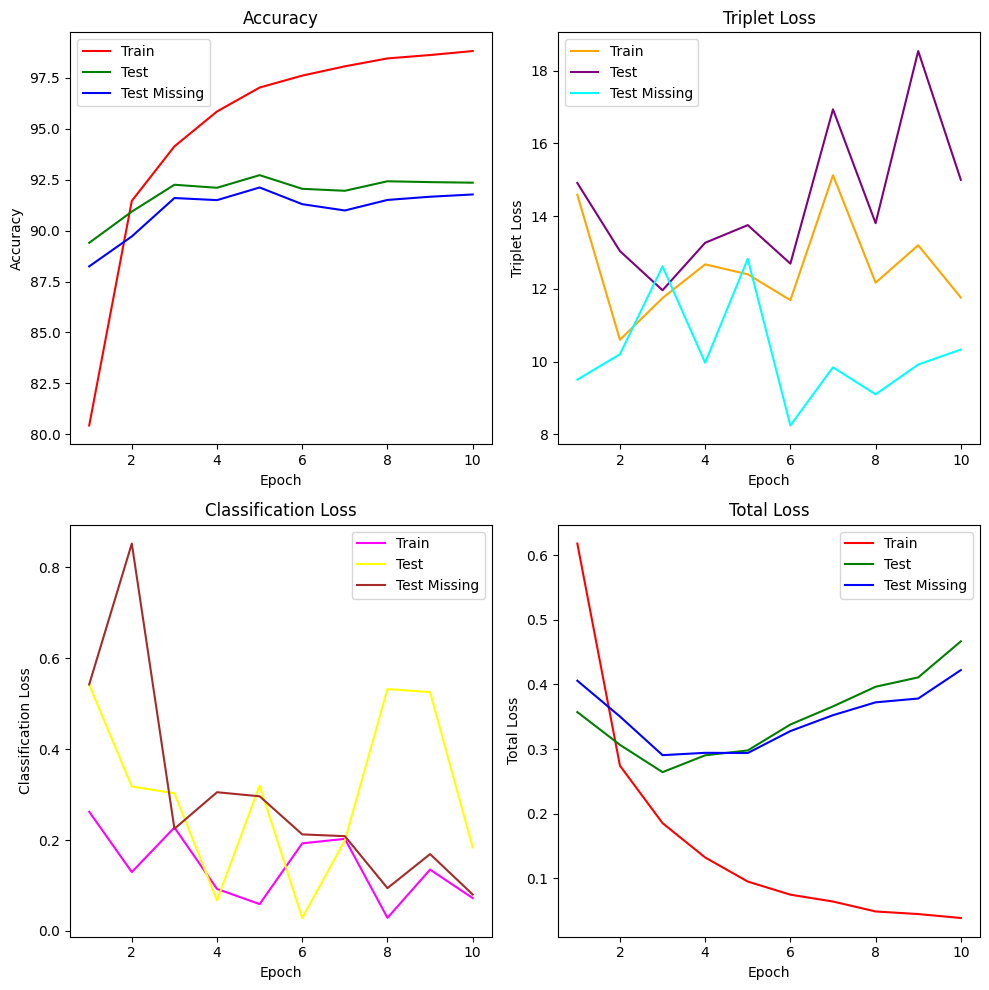

In [ ]:
info_to_plot(result[0], plot_name, True)

# 11. Adding Triplet Loss

In [ ]:
learn_rate = 0.001
lam = 2/14
alp = 0.1
plot_name = 'lam:' + str(lam) + 'learn_rate:' + str(learn_rate) + 'alp:' + str(alp) + '.png'
result = train(alp, learn_rate, lam, True, True)

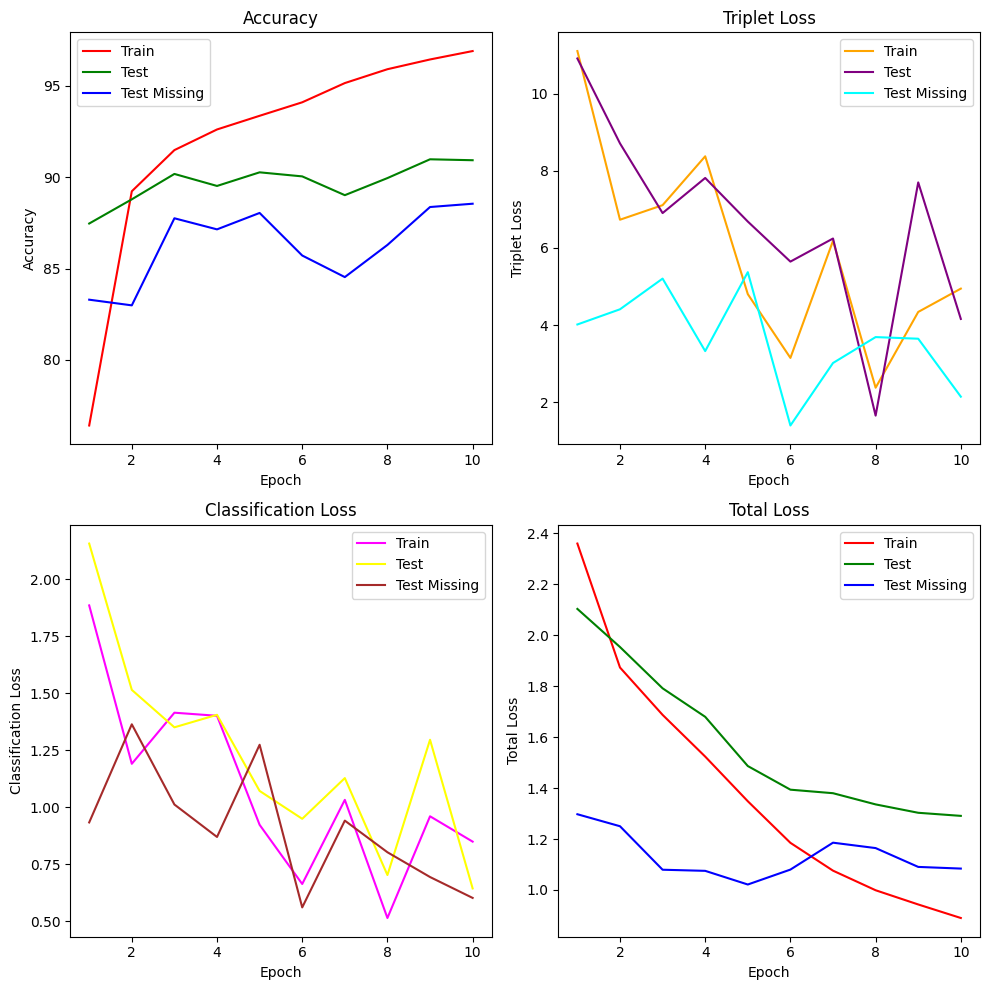

In [ ]:
info_to_plot(result[0], plot_name, True)

# SVM For Better Performance

In [ ]:
model = result[1][0]
torch.save(model.state_dict(), 'model.pth')
del result

In [12]:
model = digit_classifier_model()
model.load_state_dict(torch.load('./model.pth'))
train_features = []
train_labels = []
model.to(device)
for batch_index, (images, features, domain_labels, digit_labels) in enumerate(full_dataloaders['train']):
    for i in range(len(images)):  # beacause of ram crash -> not
        image = images[i].to(device)
        features = model(image.unsqueeze(0), [], [], 0, True)
        train_features.append(features.flatten().tolist())
        train_labels.append(digit_labels[i].item())

In [13]:
classifier = svm.SVC(kernel='rbf')
classifier.fit(train_features, train_labels)
pickle.dump(model, open('svm_model.sav', 'wb'))
predictions = classifier.predict(train_features)
accuracy = accuracy_score(predictions, train_labels)
print("Accuracy:", accuracy)
print("Confusion Matrix\n", confusion_matrix(train_labels, predictions))
del train_features
del train_labels

Accuracy: 0.96995
Confusion Matrix
 [[6222   32   18    8   12    4   28    7    8   15]
 [   6 7797   28    5   25    5    3   36    8    2]
 [  10   51 6431   17   14    7    6   19   10    7]
 [   9   60   40 5879   10   57    7   22   31   11]
 [   2   89   13    8 5643    4   13   11    5   27]
 [   6   28   15   62   14 5233   29    5   13    9]
 [  18   46    8   21   19   24 5455    1   24    9]
 [   5   78   24   11   22    4    3 5383    2   26]
 [  26   65   21   37   15   24   37    7 4955   24]
 [  29   34   27   27   25   19    7   31   12 5199]]


# 97% Accuracy On Train Data

In [75]:
classifier = pickle.load(open('svm_model.sav', 'rb'))

In [14]:
test_missing_features = []
test_missing_labels = []
for batch_index, (images, features, domain_labels, digit_labels) in enumerate(full_dataloaders['test_missing']):
    for i in range(len(images)):
        image = images[i].to(device)
        features = model(image.unsqueeze(0), [], [], 0, True)
        test_missing_features.append(features.flatten().tolist())
        test_missing_labels.append(digit_labels[i].item())
predictions = classifier.predict(test_missing_features)
accuracy = accuracy_score(predictions, test_missing_labels)
print("Accuracy:", accuracy)
print("Confusion Matrix\n", confusion_matrix(test_missing_labels, predictions))

Accuracy: 0.9098611111111111
Confusion Matrix
 [[2169   26   15    9    6    6   30    6    8   13]
 [  16 2716   22   10   23    6   11   34    3    4]
 [  11   44 2275   30   18    9    9   28   15   13]
 [   7   47   33 1850    8   60   14   13   36   23]
 [   9   50   17   11 1950    8   24    8    5   41]
 [  14   14   14   79    8 1775   33    3   12   18]
 [  37   24    7   26   22   54 1736    4   34    6]
 [   9   54   44   11   16    6    3 1846    7   39]
 [  27   20   29   67   14   30   42   18 1587   33]
 [  30   26   23   31   33   27    8   35   17 1749]]


# 91% Accuracy On Test Missing Data (And Test)